# Analyse Exploratoire

### Import des modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

<h2> Analyse Exploratoire </h2>

In [2]:
#Lecture du fichier .csv
building_consumption = pd.read_csv("C:/Users/victo/Desktop/Formation Data Scientist OpenClassRoom/Cours3/2016_Building_Energy_Benchmarking.csv")

In [3]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head(5)
# building_consumption.info()
# building_consumption.isna().sum()
# building_consumption.describe(include="all")
building_consumption['PrimaryPropertyType'].unique()

non_residential_buildings = [
    "Hotel",
    "Other",
    "K-12 School",
    "University",
    "Small- and Mid-Sized Office",
    "Self-Storage Facility",
    "Warehouse",
    "Large Office",
    "Medical Office",
    "Retail Store",
    "Hospital",
    "Distribution Center",
    "Worship Facility",
    "Supermarket / Grocery Store",
    "Laboratory",
    "Refrigerated Warehouse",
    "Restaurant",
    "Office"
]

In [4]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
# building_consumption.info()

#On supprime les outliers
building_consumption = building_consumption[(building_consumption['Outlier'].isna()) & (building_consumption['NumberofBuildings']> 0) & (building_consumption['NumberofFloors']>=0)]

#Liste des bâtiments non destinés à l'habitation ...
building_consumption = building_consumption[building_consumption['PrimaryPropertyType'].isin(non_residential_buildings)]

#### TERMINER L'ANALYSE EXPLORATOIRE 

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

Qelques pistes d'analyse : 

* Identifier les colonnes avec une majorité de valeurs manquantes ou constantes en utilisant la méthode value_counts() de Pandas
* Mettre en evidence les différences entre les immeubles mono et multi-usages
* Utiliser des pairplots et des boxplots pour faire ressortir les outliers ou des batiments avec des valeurs peu cohérentes d'un point de vue métier 

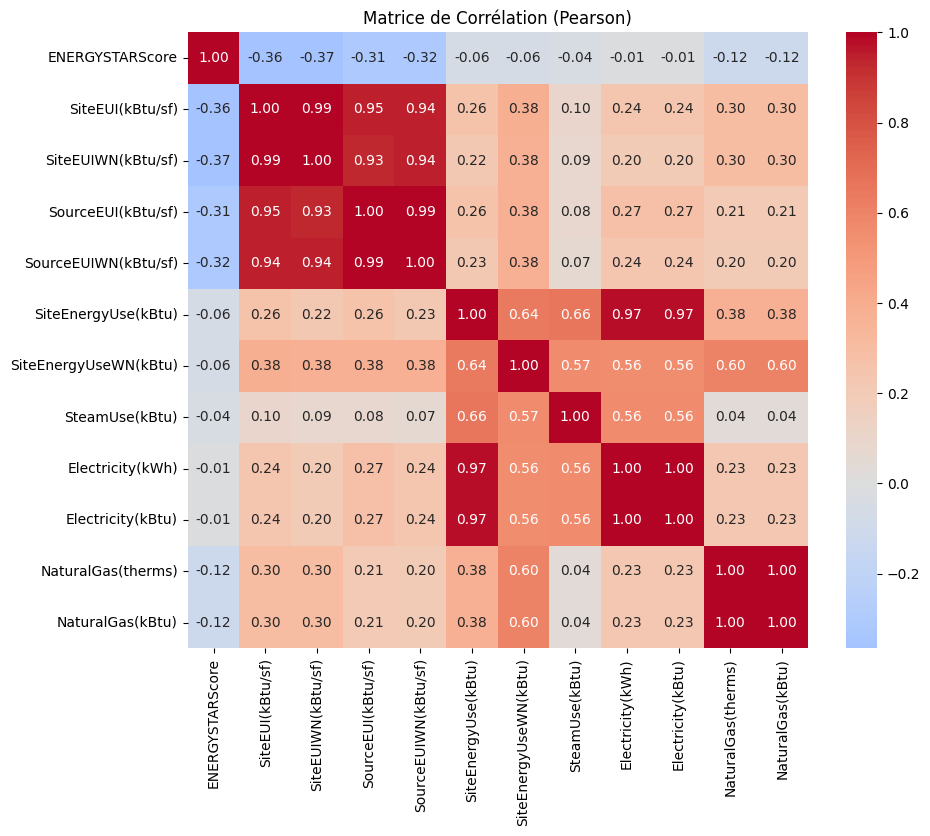

In [5]:
import numpy as np
import math

#Colonnes liées à la consommation énergétique des bâtiments
cols_energy = ['ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)','Electricity(kWh)', 'Electricity(kBtu)', 
              'NaturalGas(therms)','NaturalGas(kBtu)']

#Matrice de correlation de building_consumption_features
#Matrice de correlation de building_consumption_features
df_corr_pearson  = building_consumption[cols_energy].corr(method='pearson')
#Tracer du heatmap pearson
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matrice de Corrélation (Pearson)")
plt.show()

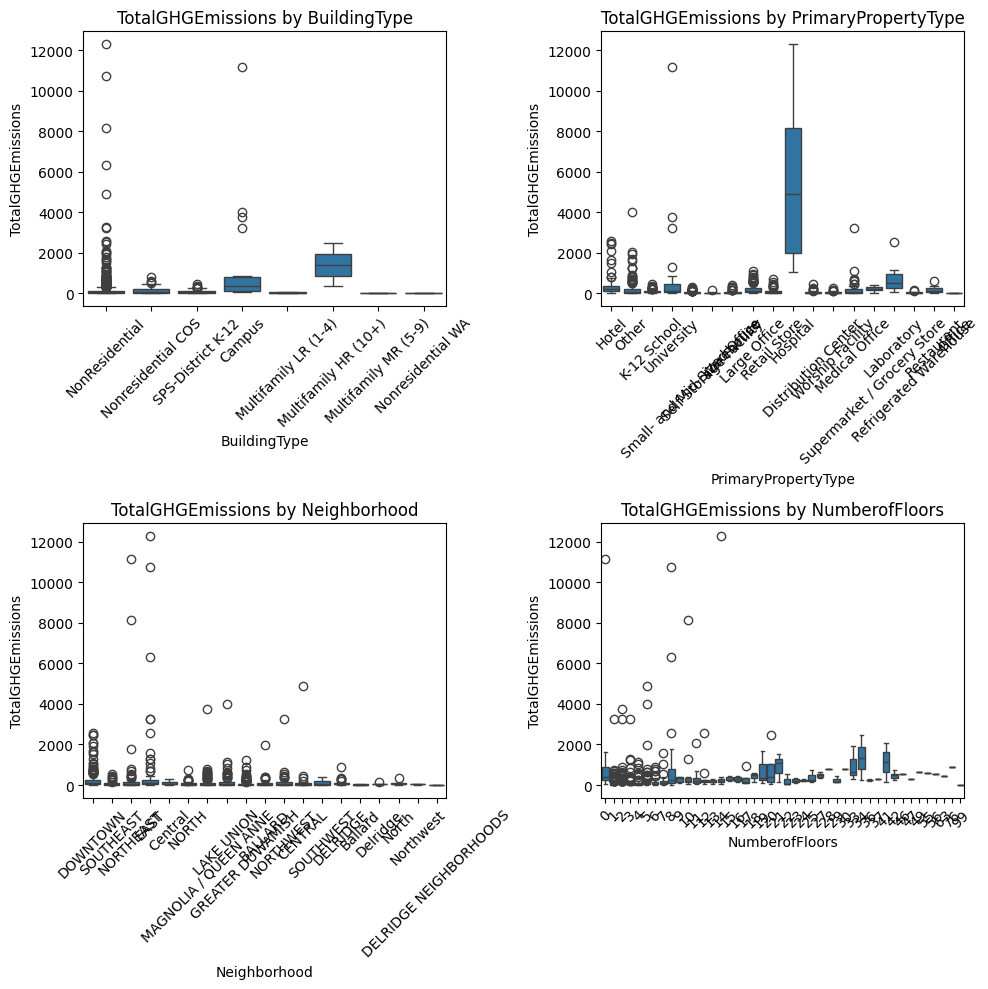

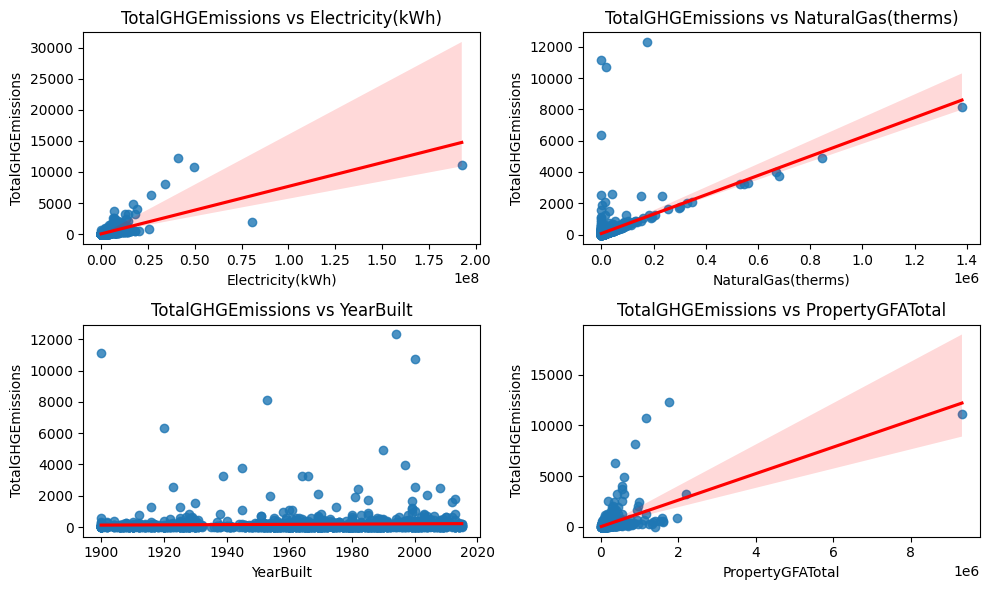

In [6]:
#Bow Plot entre mes variables quanti et quali restantes

# Colonnes quantitatives, on garde uniquement celles liées à la conso du bâtiment
quantitatives = ['Electricity(kWh)','NaturalGas(therms)','YearBuilt', 'PropertyGFATotal']

# Colonnes qualitatives, on garde que celle dont les descriptions du bâtiment peuvent expliquer sa consommation
qualitatives = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'NumberofFloors']

n = len(qualitatives)
cols = int(math.ceil(math.sqrt(n)))  # nombre de colonnes pour former un carré
rows = int(math.ceil(n / cols))      # nombre de lignes nécessaires

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()  # aplatir la grille pour itérer facilement

for i, cat_var in enumerate(qualitatives):
    sns.boxplot(x=cat_var, y='TotalGHGEmissions', data=building_consumption, ax=axes[i])
    axes[i].set_title(f"TotalGHGEmissions by {cat_var}")
    axes[i].set_xlabel(cat_var)
    axes[i].set_ylabel("TotalGHGEmissions")
    axes[i].tick_params(axis='x', rotation=45)

# Supprimer les axes vides s'il y a des cases en trop
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

def plot_linear_relationships(df, target_var, feature_vars):
    """
    Affiche les graphiques de relation linéaire entre une variable cible
    et une liste d'autres variables.

    Parameters:
        df (pd.DataFrame): Le DataFrame contenant les données.
        target_var (str): Le nom de la variable cible.
        feature_vars (list of str): Liste des variables à comparer avec la cible.
    """
    n_features = len(feature_vars)
    n_cols = 2  # nombre de colonnes dans la figure
    n_rows = (n_features + 1) // n_cols

    plt.figure(figsize=(n_cols * 5, n_rows * 3))

    for i, feature in enumerate(feature_vars):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.regplot(x=feature, y=target_var, data=df, line_kws={"color": "red"})
        plt.title(f"{target_var} vs {feature}")
    
    plt.tight_layout()
    plt.show()

plot_linear_relationships(building_consumption, 'TotalGHGEmissions', quantitatives)


Pour vous inspirer, ou comprendre l'esprit recherché dans une analyse exploratoire, vous pouvez consulter ce notebook en ligne : https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python. Il ne s'agit pas d'un modèle à suivre à la lettre ni d'un template d'analyses attendues pour ce projet. 

# Modélisation 

### Import des modules 

In [7]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [8]:
building_consumption["Neighborhood"] = building_consumption["Neighborhood"].str.upper()
building_consumption['BuildingType'].unique()


array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)',
       'Multifamily MR (5-9)', 'Nonresidential WA'], dtype=object)

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [9]:
# CODE FEATURE ENGINEERING
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Colonnes de base
numeric_cols = ['Longitude', 'Latitude']
categorical_cols_encode = ["BuildingType", "PrimaryPropertyType", "Neighborhood"]
keep_original_cols = ["PropertyGFATotal", "NumberofFloors", "YearBuilt"]

# Copier les colonnes nécessaires
building_consumption_features = building_consumption[numeric_cols + categorical_cols_encode + keep_original_cols].copy()

# -----------------------------
# Nombre d'usages dans le bâtiment
building_consumption_features['number_usage'] = building_consumption['ListOfAllPropertyUseTypes']\
    .fillna('')\
    .str.split(',')\
    .apply(lambda x: sum(bool(w.strip()) for w in x))
keep_original_cols.append('number_usage')

# -----------------------------
# Colonnes binaires pour l'utilisation d'électricité et de gaz
building_consumption_features["Uses_Electricity"] = (building_consumption["Electricity(kWh)"] > 0).astype(int)
building_consumption_features["Uses_Gas"] = (building_consumption["NaturalGas(therms)"] > 0).astype(int)
keep_original_cols += ["Uses_Electricity", "Uses_Gas"]

# -----------------------------
# Interaction PropertyGFATotal * NumberofFloors
building_consumption_features["GFA_Floors_Interaction"] = (
    building_consumption_features["PropertyGFATotal"] * building_consumption_features["NumberofFloors"]
)
keep_original_cols.append("GFA_Floors_Interaction")
# -----------------------------
# Filtrer le dataset pour ne garder que les bâtiments avec GHG > 0
mask = building_consumption["TotalGHGEmissions"] > 0
building_consumption_features = building_consumption_features.loc[mask].copy()

# Ajouter la colonne target dans le DataFrame
building_consumption_features["TotalGHGEmissions"] = building_consumption.loc[mask, "TotalGHGEmissions"]


In [10]:
def remove_outliers_iqr_drop_zeros(df, columns, drop_zeros=True):
    """
    Supprime les lignes contenant des outliers selon IQR.
    Si drop_zeros=True, supprime aussi les lignes où la valeur est 0.
    """
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"La colonne '{col}' n'existe pas dans le DataFrame")

    outlier_mask = pd.DataFrame(False, index=df.index, columns=columns)

    for col in columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Toutes les valeurs valides (non-NaN)
            valid_values = df[col][~df[col].isna()]
            if valid_values.empty:
                continue

            Q1 = valid_values.quantile(0.25)
            Q3 = valid_values.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            # Marque True pour les outliers
            outlier_mask[col] = (df[col] < lower) | (df[col] > upper)

            # Supprimer aussi les zéros si demandé
            if drop_zeros:
                outlier_mask[col] |= (df[col] == 0)

    # Supprimer les lignes qui ont au moins un outlier
    df_clean = df[~outlier_mask.any(axis=1)].copy()
    return df_clean


list_columns_to_filter = cols_energy.copy()  # copie pour garder l’original
list_columns_to_filter.append("TotalGHGEmissions")
building_consumption_features = remove_outliers_iqr_drop_zeros(building_consumption_features, ["TotalGHGEmissions", "PropertyGFATotal"])

In [11]:
# -----------------------------

# Target log-transform pour le modèle
yLog = np.log1p(building_consumption_features["TotalGHGEmissions"])

y = building_consumption_features["TotalGHGEmissions"]

# Préparation du ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore", max_categories=8), categorical_cols_encode)
    ],
    remainder="drop"
)

# Transformation
X_scaled_encoded = preprocessor.fit_transform(building_consumption_features[numeric_cols + categorical_cols_encode])
scaled_num_cols = preprocessor.named_transformers_["num"].get_feature_names_out(numeric_cols).tolist()
encoded_cat_cols = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols_encode).tolist()

X_processed = pd.DataFrame(
    X_scaled_encoded,
    columns=scaled_num_cols + encoded_cat_cols,
    index=building_consumption_features.index
)

# -----------------------------
# Ajouter les colonnes originales non scalées
X_processed = pd.concat([X_processed, building_consumption_features[keep_original_cols]], axis=1)

print("Shape final du dataset :", X_processed.shape)


Shape final du dataset : (1200, 32)


<Axes: xlabel='TotalGHGEmissions', ylabel='Count'>

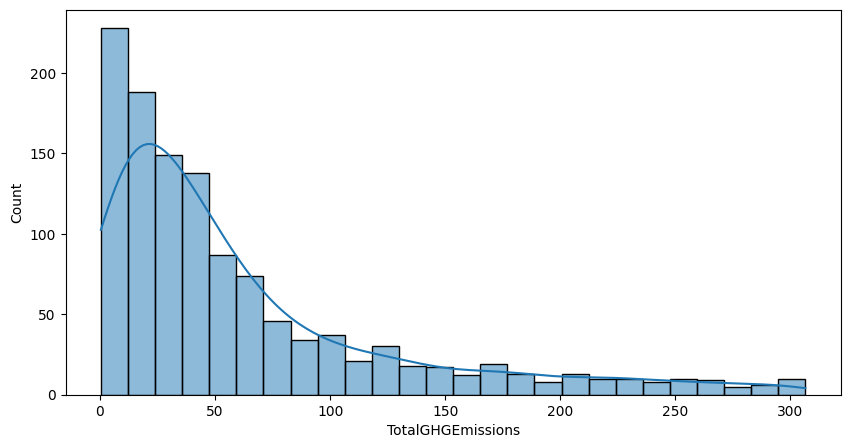

In [12]:
# CODE PREPARATION DES FEATURES

# distribution de la variable cible "TotalGHGEmissions"

plt.figure(figsize=(10, 5))

sns.histplot(data = building_consumption_features, x="TotalGHGEmissions", kde=True)

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [22]:
# CODE COMPARAISON DES MODELES
# Séparation en jeu d'apprentissage et jeu de test. 50% du dataset réservé pour le test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, yLog, test_size=0.5, random_state=42
)

# modèle Dummy regressor
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# modèle de régression SVR, on entraîne ce modèle sur les données d'apprentissage avec la méthode fit
svr = LinearSVR(C=1.0, epsilon=1.0, random_state=42)
svr.fit(X_train, y_train)

# modèle de régression linéaire, on entraîne ce modèle sur les données d'apprentissage avec la méthode fit
reg = LinearRegression()
reg.fit(X_train, y_train)

# Modèle Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)


# Modèle de type arbre décisionnel RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,  # nombre d'arbres
    max_depth=None,  # profondeur max
    random_state=42,
    n_jobs=-1,
)

# Modèle de type arbre décisionnel GradientBoostingRegressor
rf_model_gradient = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)

c:\Users\victo\Desktop\Formation Data Scientist OpenClassRoom\Cours3\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error

# Modèle à partir de PCA, on garde les 6 composantes principales
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

reg_pca = LinearRegression()
reg_pca.fit(X_train_pca, y_train)
y_pred = reg_pca.predict(X_test_pca)

# y_true et y_pred sont tes vraies valeurs et prédictions
r2 = r2_score(y_test, y_pred)

# Coefficient de corrélation R
r = np.corrcoef(y_test, y_pred)[0, 1]

# RMSE
rmse = root_mean_squared_error(y_test, y_pred)  # squared=False retourne la racine carrée

# MAE
mae = mean_absolute_error(y_test, y_pred)

#métriques
print("MSE :", mean_squared_error(y_test, y_pred))
print("Variance expliquée :", np.sum(pca.explained_variance_ratio_))
print(f"R² : {r2:.3f}")
print(f"R (corrélation) : {r:.3f}")

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")

MSE : 1.0729839619276877
Variance expliquée : 0.999999999976182
R² : 0.145
R (corrélation) : 0.381
RMSE : 1.036
MAE  : 0.842


In [24]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
)
from sklearn.model_selection import cross_val_score, cross_val_predict

# Fonction d'évaluation
def evaluate_model(model, X, y, cv=5):
    """
    Évalue un modèle de régression avec cross-validation.
    
    Paramètres
    ----------
    model : objet sklearn (ex: LinearRegression(), RandomForestRegressor(), etc.)
    X : features (DataFrame ou ndarray)
    y : target (Series ou ndarray)
    cv : nombre de folds pour la cross-validation (par défaut 5)
    
    Retourne
    --------
    dict avec les scores moyens : RMSE, MAE, MAPE, R2, r
    """

    # Scorers personnalisés
    rmse_scorer = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False)
    mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Cross-validation (métriques)
    rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    mae_scores  = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
    mape_scores = cross_val_score(model, X, y, cv=cv, scoring=mape_scorer)
    r2_scores   = cross_val_score(model, X, y, cv=cv, scoring="r2")

    # Pour r (corrélation de Pearson), il faut récupérer les prédictions
    y_pred = cross_val_predict(model, X, y, cv=cv)
    r = np.corrcoef(y, y_pred)[0, 1]

    # Moyennes (on met abs car sklearn retourne des scores négatifs avec greater_is_better=False)
    results = {
        "RMSE": abs(rmse_scores.mean()),
        "MAE": abs(mae_scores.mean()),
        "MAPE": abs(mape_scores.mean()),
        "R2": r2_scores.mean(),
        "r": r
    }

    return results

evaluate_model(dummy, X_train, y_train, cv=5)

# print("Valeurs égales à zéro dans y :", (y_train == 0).sum())


{'RMSE': np.float64(1.1487074011593876),
 'MAE': np.float64(0.9158138393079704),
 'MAPE': np.float64(0.3862315178127277),
 'R2': np.float64(-0.019062702047994852),
 'r': np.float64(-0.10588599010142932)}

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn.

In [25]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE ARBRE DECISIONNEL
# === 1. Définir la grille d’hyperparamètres ===
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
}

# === 2. Configurer GridSearchCV ===
grid = GridSearchCV(
    estimator=rf_model_gradient,
    param_grid=param_grid,
    cv=5,                        # validation croisée (k=5 folds)
    scoring="r2",                # métrique adaptée pour régression
    verbose=1,
    n_jobs=-1                    # paralléliser sur tous les cœurs
)

# === 3. Entraîner ===
grid.fit(X_train, y_train)

# === 4. Résultats ===
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score (CV) :", grid.best_score_)

# === 5. Évaluation sur le test set ===
y_pred = grid.predict(X_test)
print("R² (test) :", r2_score(y_test, y_pred))
print("RMSE (test) :", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres : {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score (CV) : 0.40864810515981526
R² (test) : 0.46563055140512855
RMSE (test) : 0.818814050364338


In [26]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE REGRESSION LINEAIRE
# === 1. Définir la grille d’hyperparamètres ===
# Hyperparamètres à tester
param_grid = {
    "fit_intercept": [True, False],
    "copy_X": [True, False]
}

# === 2. Configurer GridSearchCV ===
grid = GridSearchCV(
    ridge,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    verbose=1
)

# === 3. Entraîner ===
grid.fit(X_train, y_train)

# === 4. Résultats ===
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# === 5. Évaluation sur le test set ===
y_pred = grid.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'copy_X': True, 'fit_intercept': False}
Best CV score: 0.4104381529710559
Test R²: 0.48700455293902667
Test RMSE: 0.8022712541578665


In [27]:
from sklearn.model_selection import GridSearchCV

# 🔎 Grille d’hyperparamètres à tester
param_grid = {
    "n_estimators": [100, 200, 500],      # nombre d’arbres
    "learning_rate": [0.01, 0.05, 0.1],  # taux d’apprentissage
    "max_depth": [3, 5, 7],              # profondeur max des arbres
    "min_samples_split": [2, 5, 10],     # min observations pour split
    "min_samples_leaf": [1, 3, 5]        # min observations dans une feuille
}

# 🚀 GridSearchCV
grid_search = GridSearchCV(
    rf_model_gradient,
    param_grid,
    cv=5,
    scoring="r2",    # tu peux mettre "neg_mean_squared_error"
    n_jobs=-1,
    verbose=2
)

# 📊 Entraînement
grid_search.fit(X_train, y_train)

# 🔎 Meilleurs hyperparamètres
print("Meilleurs paramètres :", grid_search.best_params_)

# 🏆 Score moyen en cross-validation
print("Meilleur score CV (R²):", grid_search.best_score_)

# ✅ Évaluation sur le test set
best_gbr = grid_search.best_estimator_
y_pred = best_gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE (test):", rmse)
print("R² (test):", r2)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Meilleur score CV (R²): 0.46328972254651807
RMSE (test): 0.790788259976857
R² (test): 0.5015845754041791


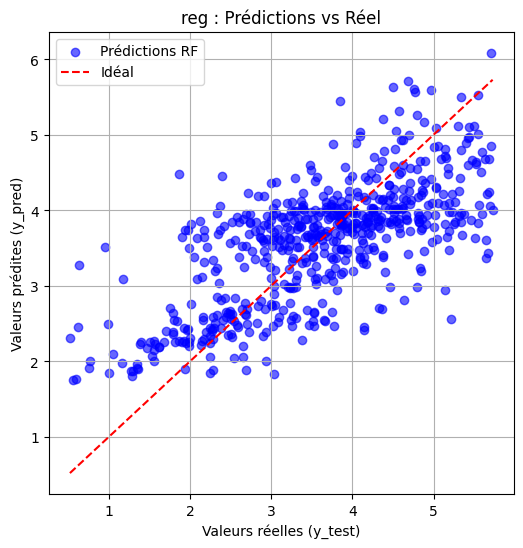

In [28]:
def plot_model(model):
    # prédictions RandomForest
    model.fit(X_train, y_train)
    y_pred_rf = model.predict(X_test)
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred_rf, alpha=0.6, color="blue", label="Prédictions RF")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Idéal")
    
    plt.xlabel("Valeurs réelles (y_test)")
    plt.ylabel("Valeurs prédites (y_pred)")
    plt.title("reg : Prédictions vs Réel")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

plot_model(reg)

# Analyser l'erreur

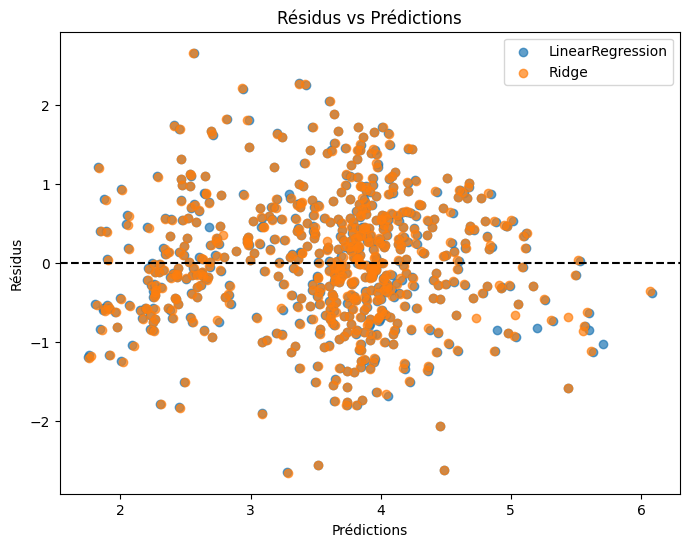

In [29]:
def plot_residuals(y_true, predictions_dict):
    """
    Affiche les résidus vs prédictions pour plusieurs modèles.
    
    Parameters
    ----------
    y_true : array-like
        Valeurs réelles.
    predictions_dict : dict
        Dictionnaire {"Nom du modèle": y_pred}.
    """
    plt.figure(figsize=(8, 6))
    
    for name, y_pred in predictions_dict.items():
        residuals = y_true - y_pred
        plt.scatter(y_pred, residuals, alpha=0.7, label=name)
    
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Prédictions")
    plt.ylabel("Résidus")
    plt.title("Résidus vs Prédictions")
    plt.legend()
    plt.show()

#Y prédit
y_pred_lr = reg.predict(X_test)
y_pred_ridge = ridge.predict(X_test)

#résidus
residuals_lr = y_test - y_pred_lr
residuals_ridge = y_test - y_pred_ridge

plot_residuals(y_test, {
    "LinearRegression": y_pred_lr,
    "Ridge": y_pred_ridge
})